# Plant Seedlings Classification

This notebook documents the process to achieve around 0.97858 on the leaderboard.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [103]:
import os
import random
import shutil
from collections import Counter

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from fastai import transforms
from fastai import conv_learner
from fastai import model
from fastai import dataset
from fastai import sgdr
from fastai import plots

from torchvision.models import resnet50
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torchvision.transforms import RandomRotation, ColorJitter, RandomAffine, Compose
from tqdm import tqdm_notebook
import pandas as pd

In [5]:
PATH = './data/plant-seedlings-classification/'
sz = 224
arch = resnet50

## Download and prepare dataset

In [4]:
!kaggle competitions download -c plant-seedlings-classification --path='{PATH}'

sample_submission.csv.zip: Downloaded 5KB of 5KB
test.zip: Downloaded 86MB of 86MB
train.zip: Downloaded 2GB of 2GB2GB


In [5]:
!ls -l {PATH}

total 1766296
-rw-rw-r-- 1 ubuntu ubuntu       5251 Apr 27 05:31 sample_submission.csv.zip
-rw-rw-r-- 1 ubuntu ubuntu   90141460 Apr 27 05:31 test.zip
-rw-rw-r-- 1 ubuntu ubuntu 1718530069 Apr 27 05:31 train.zip


In [6]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}{file}

## Examine dataset

### Examples from each class

In [8]:
class_names = os.listdir(f'{PATH}train')

imgs = []
for class_name in class_names:
    filename = os.listdir(f'{PATH}train/{class_name}')[0]
    
    imgs.append(Image.open(f'{PATH}train/{class_name}/{filename}'))

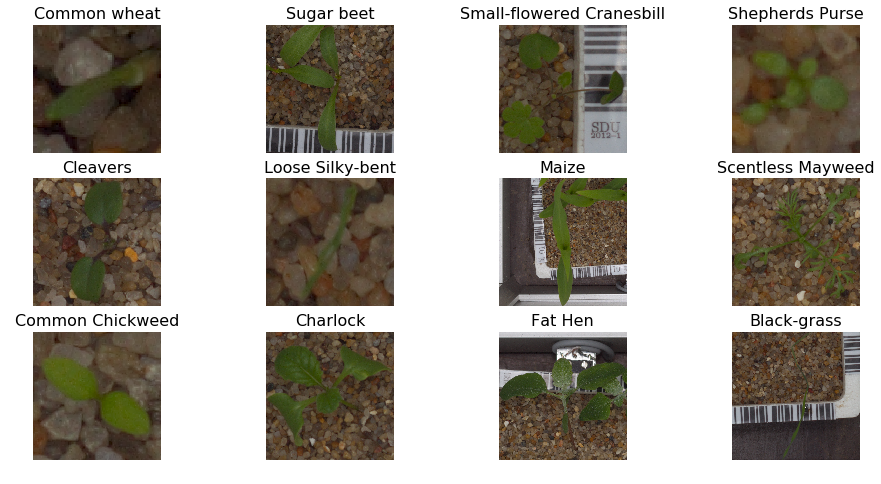

In [19]:
plots.plots(imgs, rows=3, titles=class_names, figsize=(16,8))

### Image size distribution

In [27]:
widths, heights = [], []

for class_name in class_names:
    for f in os.listdir(f'{PATH}train/{class_name}'):
        width, height = Image.open(f'{PATH}/train/{class_name}/{f}').size
        widths.append(width)
        heights.append(height)

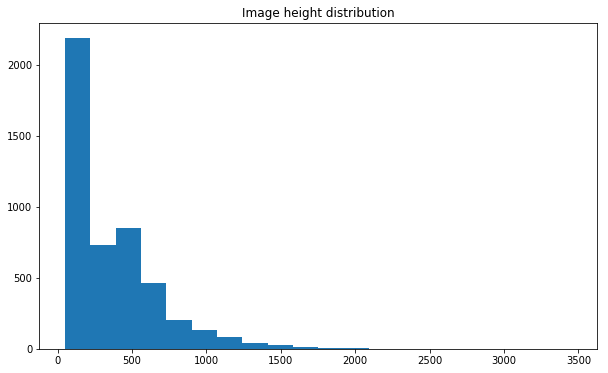

In [49]:
plt.figure(figsize=(10, 6))
plt.title("Image height distribution")
plt.hist(heights, bins=20)
plt.show()

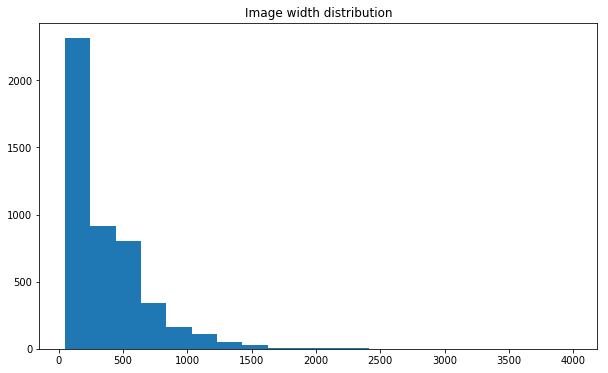

In [48]:
plt.figure(figsize=(10, 6))
plt.title("Image width distribution")
plt.hist(widths, bins=20)
plt.show()

Images are generally quite small and the vast majority are around 100x100.

### Images per class (dataset "balanced-ness")

In [41]:
class_num = {}

# Get number of images per class
for class_name in class_names:
    class_num[class_name] = len(os.listdir(f'{PATH}train/{class_name}'))

# Sort by class length
class_num_sorted = sorted(class_num.items(), key=lambda x: x[1], reverse=True)


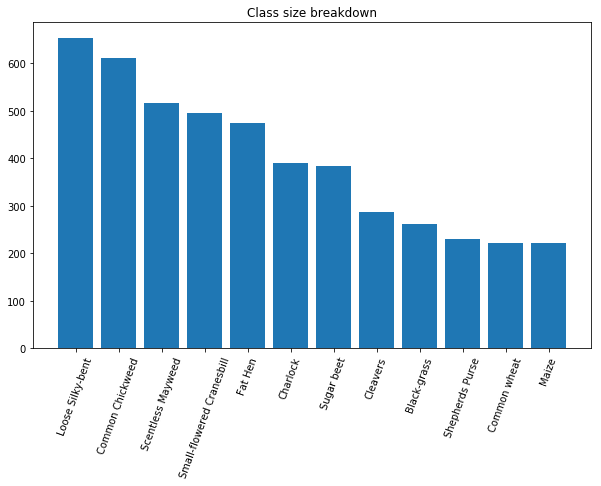

In [51]:
plt.figure(figsize=(10, 6))

labels = [a[0] for a in class_num_sorted]
counts = [a[1] for a in class_num_sorted]

plt.bar(labels, counts, align='center')
plt.xticks(labels, rotation=70)
plt.title("Class size breakdown")
plt.show()

In [52]:
print("Total images:", sum(counts))

Total images: 4750


So, the classes look a little unbalanced and could possibly benefit from some work to balance them. One obvious approach might be to create duplicate augmented images for all the classes with less images than the largest class.

## Create validation set

A simple approach to creating a validation set is to randomly move an image to the validation set, with a probabilty that matches the size of the desired validation set. In this example, i'll aim to move around 10% of the images to the validation set. That should give us a validation set with around 950 images.

In [53]:
random.seed(42)

In [54]:
!mkdir {PATH}valid

I'll create a copy of the train directory, to preserve the original.

In [56]:
!cp -r {PATH}train {PATH}train_limited

In [57]:
all_files = []

for class_dir in os.listdir(f'{PATH}train_limited'):
    os.makedirs(f'{PATH}valid/{class_dir}', exist_ok=True)
    
    for file in os.listdir(f'{PATH}train_limited/{class_dir}'):
        rand = random.random()

        if rand > 0.8:
            shutil.move(f'{PATH}train_limited/{class_dir}/{file}', f'{PATH}valid/{class_dir}/{file}')

In [2]:
PATH

'./data/plant-seedlings-classification/'

## Train using "basic steps"

In [6]:
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [7]:
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

/home/ubuntu/src/anaconda3/envs/plant-seedlings/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


### Find learning rate

In [63]:
learn.lr_find()

 70%|███████   | 42/60 [00:01<00:00, 35.37it/s, loss=14.5]


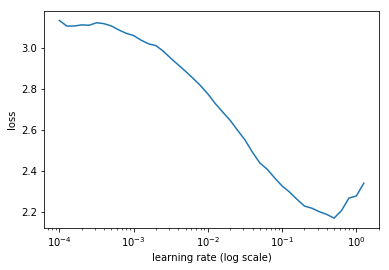

In [64]:
learn.sched.plot()

In [65]:
lr = 0.1

### Train last layer with precomputed activations

In [66]:
learn.fit(lr, 10)

epoch      trn_loss   val_loss   accuracy                 
    0      1.333361   0.771577   0.765273  
    1      0.945175   0.629714   0.817792                  
    2      0.693215   0.526272   0.834941                  
    3      0.505645   0.477886   0.846731                  
    4      0.421069   0.463597   0.846731                  
    5      0.350388   0.586572   0.860665                  
    6      0.290591   0.449703   0.872454                  
    7      0.264498   0.45286    0.860665                  
    8      0.258396   0.434632   0.869239                  
    9      0.227831   0.467335   0.87567                   



[0.4673346357074709, 0.8756698812063611]

### Train last layer with augmentations

In [8]:
learn.precompute = False

In [68]:
learn.fit(lr, 6, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.506304   0.406529   0.877814  
    1      0.487499   0.377221   0.881029                  
    2      0.449735   0.348538   0.894962                  
    3      0.415475   0.361667   0.891747                  
    4      0.411226   0.343926   0.893891                  
    5      0.40619    0.341268   0.892819                  



[0.3412682549171509, 0.8928188634327626]

### Train earlier layers

In [69]:
learn.unfreeze()

In [71]:
learn.lr_find()

 92%|█████████▏| 55/60 [01:25<00:07,  1.56s/it, loss=4.61]

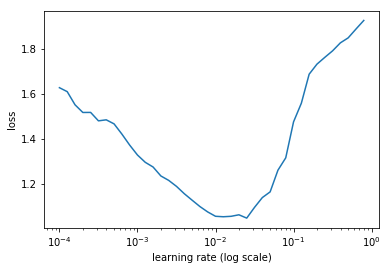

In [72]:
learn.sched.plot()

In [73]:
lr = 0.01
lrs = np.array([lr/9, lr/3, lr])

In [74]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  2%|▏         | 1/60 [00:06<06:39,  6.77s/it, loss=2.08]
epoch      trn_loss   val_loss   accuracy                  
    0      0.423087   0.276935   0.906752  
    1      0.280126   0.214715   0.937835                  
    2      0.191486   0.20006    0.944266                  
    3      0.176879   0.202057   0.939979                  
    5      0.108546   0.156445   0.953912                  
    6      0.08554    0.157104   0.954984                   



[0.15710393268323533, 0.9549839217435381]

In [75]:
learn.save(f'resnet50_{sz}')

In [76]:
learn.load(f'resnet50_{sz}')

Looks like we're starting to overfit. Will try increasing the image size.

In [78]:
sz = 300
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [79]:
learn.set_data(data)

In [80]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  2%|▏         | 1/60 [00:06<06:41,  6.81s/it, loss=0.118]
epoch      trn_loss   val_loss   accuracy                  
    0      0.120287   0.147179   0.956056  
    1      0.107078   0.142831   0.953912                  
    2      0.090999   0.141939   0.959271                   
    3      0.08802    0.138441   0.963558                   
    4      0.081874   0.137054   0.961415                   
    5      0.085121   0.138564   0.959271                   
    6      0.082152   0.136107   0.962487                   



[0.13610679112446653, 0.9624866029968343]

In [83]:
learn.save(f'resnet50_{sz}_2')

In [84]:
learn.load(f'resnet50_{sz}_2')

Helped a bit. Try going up in size again.

In [9]:
sz = 400
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [86]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name=f'resnet50_{sz}_3')

epoch      trn_loss   val_loss   accuracy                   
    0      0.076306   0.135974   0.962487  
    1      0.087006   0.134248   0.962487                   
    2      0.08117    0.13495    0.965702                   
    3      0.076928   0.132484   0.96463                    
    4      0.077252   0.130758   0.96463                    
    5      0.075765   0.130334   0.965702                   
    6      0.076002   0.129528   0.962487                   



[0.1295282036736847, 0.9624866029968343]

In [87]:
learn.save(f'resnet50_{sz}_3')

In [10]:
learn.load(f'resnet50_{sz}_3')

## Evaluation

### f1 score

In [12]:
aug_log_preds, targs = learn.TTA()
log_preds = np.mean(aug_log_preds, axis=0)

In [13]:
f1_score(targs, np.argmax(log_preds, axis=1), average='macro')

0.9533181287721465

### Confusion matrix

In [14]:
cm = confusion_matrix(targs, np.argmax(log_preds, axis=1))

[[ 29   0   0   0   2   0  14   0   0   0   0   0]
 [  0  69   0   0   0   0   0   0   0   0   0   0]
 [  0   0  59   2   0   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   1   0   0   1   0   0]
 [  0   0   0   0  46   0   0   1   0   0   0   1]
 [  0   0   0   0   1  82   0   0   0   0   0   1]
 [  3   0   0   0   0   0 128   0   0   0   0   0]
 [  0   0   0   0   0   0   0  39   0   0   0   0]
 [  0   1   0   2   0   0   0   0 107   1   0   0]
 [  0   0   0   0   0   0   0   0   1  41   0   0]
 [  0   1   0   0   0   0   1   0   0   0  97   0]
 [  0   0   0   1   0   1   1   0   0   0   0  76]]


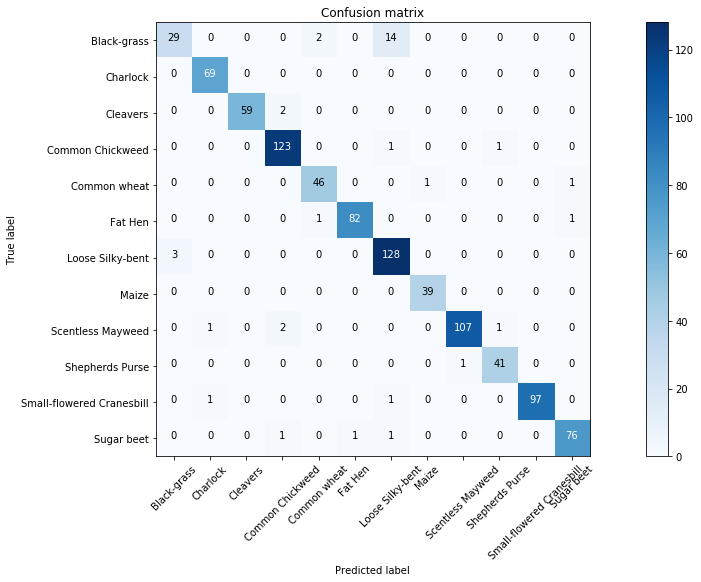

In [15]:
plots.plot_confusion_matrix(cm, classes=learn.data.classes, figsize=(16,8))

We can see that `Black grass` was predicted as `Loose Silky-bent` around 14 times. Black grass is one of the classes with fewer images and `Loose Silky-bent` has the most, so it might be worth trying to balance the dataset and retrain.

## Balance dataset

Thanks to Mitchell for the awesome idea.

1. Find the largest class.
2. Walk through every other class and randomly select and image, perform an augmentation and save.
3. Repeat 2 until it has the same number of training examples as the largest class.

In [16]:
!cp -r {PATH}train_limited {PATH}train_balanced

In [24]:
class_names = os.listdir(f'{PATH}train')

# Get number of images per class
class_num = {class_name: len(os.listdir(f'{PATH}train_balanced/{class_name}')) for class_name in class_names}

largest_cls_name, largest_cls_count = sorted(class_num.items(), key=lambda x: x[1], reverse=True)[0]

In [25]:
largest_cls_name, largest_cls_count

('Loose Silky-bent', 523)

In [56]:
tfms = [RandomRotation(10), ColorJitter(0.05, 0.05), RandomAffine(10)]

for class_name in class_names:
    all_images = [i for i in os.listdir(f'{PATH}train_balanced/{class_name}') if 'aug' not in i]
    num_images = len(all_images)
    
    images_to_add = largest_cls_count - num_images
    
    print(f'Doing {class_name}.')
    
    for i in tqdm_notebook(range(images_to_add)):
        filename = random.choice(all_images)
        img = Image.open(f'{PATH}train_balanced/{class_name}/{filename}')
        img = composition(img)
        img.save(f'{PATH}train_balanced/{class_name}/aug_{i}.png')

Doing Common wheat.




Doing Sugar beet.



Doing Small-flowered Cranesbill.



Doing Shepherds Purse.



Doing Cleavers.



Doing Loose Silky-bent.



Doing Maize.



Doing Scentless Mayweed.



Doing Common Chickweed.



Doing Charlock.



Doing Fat Hen.



Doing Black-grass.


Plot a few examples to make sure they look about right.

In [62]:
filenames = [i for i in os.listdir(f'{PATH}train_balanced/Black-grass') if 'aug' in i][:8]
imgs = [Image.open(f'{PATH}train_balanced/Black-grass/{f}') for f in filenames]

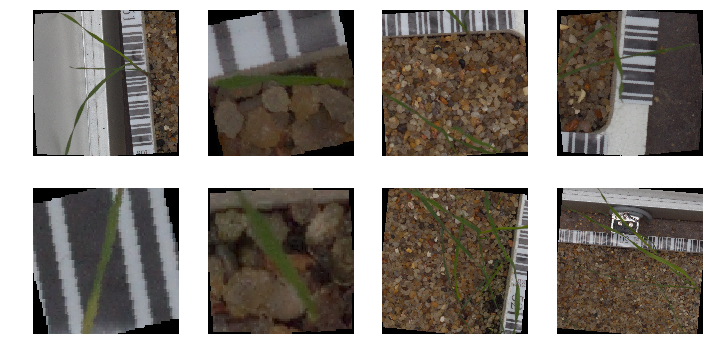

In [63]:
plots.plots(imgs, rows=2)

In [83]:
sz = 300
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_balanced', val_name='valid', test_name='test', tfms=tfms)

In [84]:
learn.set_data(data)

In [69]:
learn.load(f'resnet50_400_3')

In [71]:
lr = 0.01
lrs = np.array([lr/9, lr/3, lr])

In [72]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name=f'resnet50_bal_{sz}_1')

epoch      trn_loss   val_loss   accuracy                   
    0      0.108441   0.135597   0.961415  
    1      0.103798   0.132161   0.960343                   
    2      0.130165   0.144259   0.962487                   
    3      0.087865   0.13579    0.963558                   
    4      0.094846   0.137421   0.958199                   
    5      0.086749   0.135993   0.962487                   
    6      0.155661   0.13145    0.967846                   



[0.13144954906463113, 0.9678456598028365]

In [73]:
lr = 0.005
lrs = np.array([lr/9, lr/3, lr])

In [74]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name=f'resnet50_bal_{sz}_2')

epoch      trn_loss   val_loss   accuracy                   
    0      0.084973   0.138033   0.963558  
    1      0.084614   0.132789   0.966774                   
    2      0.077067   0.135984   0.958199                   
    3      0.079643   0.136837   0.960343                   
    4      0.077644   0.138826   0.962487                   
    5      0.079565   0.133057   0.965702                   
    6      0.107522   0.135716   0.962487                   



[0.13571575391011478, 0.9624866029968343]

In [85]:
learn.load_cycle(f'resnet50_bal_300_2', 1)

In [86]:
aug_log_preds, targs = learn.TTA()
log_preds = np.mean(aug_log_preds, axis=0)

In [87]:
f1_score(targs, np.argmax(log_preds, axis=1), average='macro')

0.9577761376156425

In [88]:
cm = confusion_matrix(targs, np.argmax(log_preds, axis=1))

[[ 37   0   0   0   2   0   6   0   0   0   0   0]
 [  0  68   0   0   0   0   0   0   0   0   0   1]
 [  0   0  59   1   1   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   1   0   0   1   0   0]
 [  0   0   0   0  47   0   0   0   0   0   0   1]
 [  0   0   0   0   1  83   0   0   0   0   0   0]
 [ 12   0   0   0   0   0 119   0   0   0   0   0]
 [  0   0   0   0   1   0   0  38   0   0   0   0]
 [  0   0   0   0   0   0   0   0 111   0   0   0]
 [  0   0   0   0   0   0   0   0   2  40   0   0]
 [  1   0   1   0   0   0   0   0   0   0  97   0]
 [  0   0   0   0   0   0   1   0   1   0   0  77]]


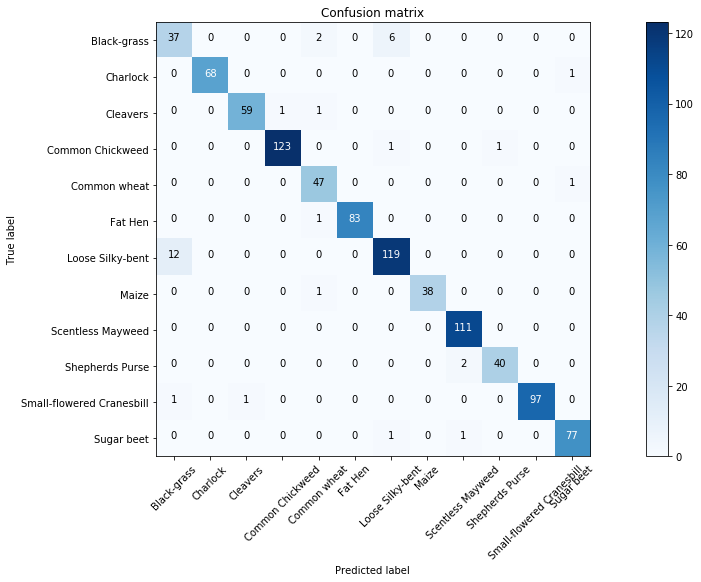

In [89]:
plots.plot_confusion_matrix(cm, classes=learn.data.classes, figsize=(16,8))

## Train on full dataset

In [91]:
!cp -r {PATH}train_balanced {PATH}train_balance_fs

In [92]:
for class_dir in os.listdir(f'{PATH}valid'):
    for file in os.listdir(f'{PATH}valid/{class_dir}'):
        shutil.copy(f'{PATH}valid/{class_dir}/{file}', f'{PATH}train_balance_fs/{class_dir}/{file}')

In [93]:
sz = 224
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_balance_fs', val_name='valid', test_name='test', tfms=tfms)

In [95]:
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

/home/ubuntu/src/anaconda3/envs/plant-seedlings/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 113/113 [01:03<00:00,  1.77it/s]


In [96]:
lr = 0.1
learn.fit(lr, 10)

epoch      trn_loss   val_loss   accuracy                   
    0      1.113493   0.534116   0.825295  
    1      0.662867   0.520295   0.859593                   
    2      0.506429   0.262008   0.909968                   
 72%|███████▏  | 81/113 [00:02<00:00, 39.39it/s, loss=0.426]
    3      0.409095   0.274791   0.928189                   
    4      0.373304   0.234705   0.917471                   
    5      0.3273     0.223382   0.943194                    
    6      0.351124   0.135429   0.948553                    
    7      0.281292   0.217422   0.957128                   
    8      0.277858   0.103813   0.962487                    
    9      0.223092   0.122584   0.966774                   



[0.1225842661349081, 0.9667738479944415]

In [97]:
learn.precompute = False
learn.fit(lr, 6, cycle_len=1)
learn.unfreeze()
lr = 0.01
lrs = np.array([lr/9, lr/3, lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
sz=300
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_balance_fs', val_name='valid', test_name='test', tfms=tfms)
learn.set_data(data)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.521081   0.103914   0.975348  
    1      0.478273   0.112347   0.968917                    
    2      0.422395   0.106384   0.973205                    
    3      0.429211   0.10842    0.971061                    
    4      0.397861   0.109854   0.969989                    
    5      0.390734   0.108989   0.972133                    



epoch      trn_loss   val_loss   accuracy                    
    0      0.303827   0.171675   0.947481  
    1      0.181734   0.103002   0.971061                    
    2      0.115884   0.083385   0.977492                    
    3      0.115895   0.077597   0.97642                     
    4      0.084531   0.062197   0.978564                     
    5      0.061982   0.049267   0.987138                     
    6      0.050027   0.049045   0.986066                     



epoch      trn_loss   val_loss   accuracy                     
    0      0.068244   0.06721    0.982851  
    1      0.057659   0.06507    0.980707                     
    2      0.06191    0.064318   0.981779                     
    3      0.054925   0.061562   0.986066                     
    4      0.05916    0.060262   0.981779                     
    5      0.062568   0.060848   0.982851                     
    6      0.057933   0.059692   0.986066                     



[0.0596917840549353, 0.9860664523043944]

In [118]:
lr = 0.001

In [119]:
lrs = np.array([lr/9, lr/3, lr])

In [120]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047121   0.046083   0.982851  
    1      0.048792   0.044901   0.983923                     
    2      0.044032   0.044876   0.984995                     
    3      0.048545   0.044722   0.984995                     
    4      0.04694    0.045708   0.982851                     
    5      0.050921   0.046441   0.981779                     
    6      0.053359   0.04672    0.983923                     



[0.04671967937536178, 0.9839228302208429]

In [121]:
aug_log_preds, _ = learn.TTA(is_test=True)

In [122]:
log_preds = np.mean(aug_log_preds, axis=0)

In [123]:
preds = np.argmax(log_preds, axis=1)

In [124]:
fnames = [f[5:] for f in learn.data.test_ds.fnames]
classes = [learn.data.classes[i] for i in preds]

In [125]:
df = pd.DataFrame({'file': fnames, 'species': classes})

In [126]:
df.to_csv(f'{PATH}sub.csv', index=False)

In [127]:
from IPython.lib.display import FileLink

In [128]:
FileLink(f'{PATH}sub.csv',)

/home/ubuntu/notebooks/kaggle/plant-seedlings-classification/data/plant-seedlings-classification/sub.csv

This gets around 0.97858 on the leaderboard.